# **STEMfit example**

This notebook gives a short demonstration of how to detect atoms in a STEM image and determine the unit cell. First, we start by importing `STEMfit`:

In [6]:
using Pkg; Pkg.activate("X:\\Documents\\virtualenvs\\Julia_STEMfit");
Pkg.update("STEMfit")
import STEMfit

  Activating project at `X:\Documents\virtualenvs\Julia_STEMfit`


Now, we load our example image. By setting `convert=true`, we let `STEMfit` convert our 16 bit TIFF image into the required format.

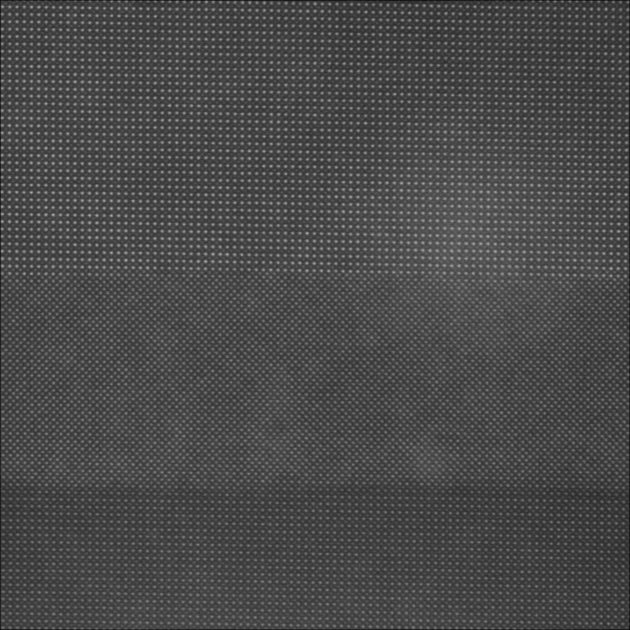

In [4]:
image = STEMfit.load_image("image.tif", convert=true)

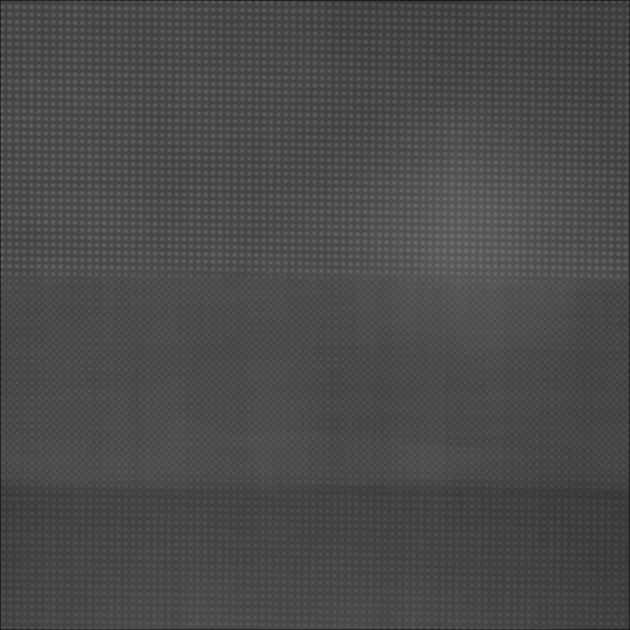

In [14]:
filtered_image = STEMfit.filter_image(image, num_sv = 20)

Then, we use the `find_atoms` function to find atoms in the image using an adaptive thresholding procedure. The function takes the image as an argument as well as `bias` and `window_size` parameters which control the thresholding. Increasing `bias` tends to make the threshold higher (i.e. more separation of atoms), `window_size` determines how big of an area is considered at each point in the image. The function returns a matrix of atom positions, a vector of atom widths, a vector of atom intensities and the thresholded image. The latter can be used to assess the quality of the thresholding and asjust the `bias` and `window_size` parameters. 

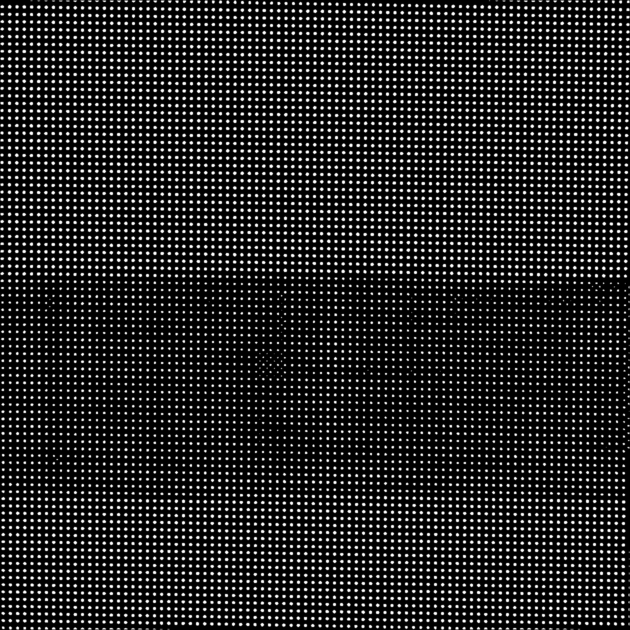

In [26]:
(atom_positions, atom_widths, atom_intensities, thresholded_image) = STEMfit.find_atoms(filtered_image, bias=1.5, window_size=10)
thresholded_image